###**Load Dataset**

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [2]:
data_patch = "/kaggle/input/flower/flower_photos"

In [3]:
dataset = ImageFolder(root=data_patch)

In [4]:
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

In [5]:
num_classes

5

In [6]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

In [7]:
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

###**Preprocessing**

In [8]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [9]:
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

###**Dataloader**

In [10]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

###**Modeling**

In [11]:
class TransformerEncoder(nn.Module):
    def __init__ (self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim = embed_dim,
            num_heads = num_heads,
            batch_first = True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features = ff_dim, bias = True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features = embed_dim, bias = True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape = embed_dim, eps = 1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape = embed_dim, eps = 1e-6)
        self.dropout_1 = nn.Dropout(p = dropout)
        self.dropout_2 = nn.Dropout(p = dropout)
    
    def forward(self, query , key , value):
        attn_output, _ = self.attn(query , key , value)    
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(attn_output + query)

        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        output = self.layernorm_2(out_1 + ffn_output)

        return output

class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

        x = x + self.positional_embedding.to(self.device)
        return x


In [12]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        # self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [13]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)

In [16]:
model.to(device)

VisionTransformerCls(
  (embd_layer): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
  )
  (transformer_layer): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=512, bias=True)
    )
    (layernorm_1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (layernorm_2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (dropout_1): Dropout(p=0.1, inplace=False)
    (dropout_2): Dropout(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=512, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [17]:
input, label = next(iter(train_loader))

In [18]:
input = input.to(device)

In [19]:
label

tensor([2, 2, 3, 4, 1, 2, 1, 1, 2, 3, 4, 2, 3, 3, 3, 4, 2, 3, 4, 0, 3, 1, 2, 0,
        4, 1, 3, 2, 3, 4, 3, 0, 1, 3, 4, 1, 2, 3, 0, 3, 2, 2, 0, 1, 1, 3, 4, 3,
        1, 0, 1, 1, 2, 4, 1, 1, 4, 0, 1, 1, 4, 1, 0, 2, 4, 3, 2, 2, 4, 4, 4, 2,
        3, 0, 3, 4, 0, 0, 3, 3, 0, 2, 2, 0, 1, 2, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 0, 3, 2, 4, 1, 1, 4, 3, 1, 2, 1, 4, 4, 2, 1, 3, 0, 1, 2, 3, 4,
        3, 1, 3, 4, 4, 4, 4, 1, 3, 4, 0, 0, 2, 1, 4, 3, 4, 1, 2, 4, 2, 4, 1, 2,
        4, 3, 4, 2, 2, 3, 2, 0, 1, 4, 0, 3, 0, 4, 4, 3, 0, 1, 0, 0, 1, 1, 1, 3,
        3, 2, 1, 4, 3, 0, 2, 4, 0, 1, 0, 4, 4, 0, 3, 3, 4, 0, 3, 0, 0, 0, 4, 2,
        2, 4, 1, 0, 2, 4, 4, 1, 1, 4, 1, 1, 2, 1, 3, 0, 3, 0, 0, 4, 3, 3, 0, 0,
        0, 4, 3, 2, 1, 1, 4, 3, 1, 1, 2, 3, 4, 2, 3, 0, 1, 0, 1, 1, 0, 2, 4, 0,
        4, 3, 0, 0, 3, 3, 4, 1, 4, 4, 4, 2, 3, 3, 2, 4, 2, 2, 4, 2, 0, 0, 3, 2,
        4, 2, 2, 1, 4, 0, 1, 3, 2, 1, 1, 2, 3, 2, 4, 1, 2, 4, 1, 4, 3, 2, 3, 0,
        1, 0, 2, 2, 1, 2, 0, 3, 0, 2, 3,

In [20]:
predictions = model(input)

In [21]:
predictions

tensor([[-0.0712, -0.0450, -0.4631,  0.4641, -0.2508],
        [ 0.3158, -0.1731,  0.6986, -0.3745,  0.0805],
        [-0.0580, -0.2239, -0.0463,  0.2438,  0.1799],
        ...,
        [-0.0208,  0.5172,  0.2299, -0.6506,  0.6554],
        [ 0.5062, -0.4043,  0.1209, -0.4201,  0.4628],
        [-0.3904,  0.0184, -0.4500, -0.0122,  0.0576]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

##**Trainer**

In [22]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [23]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [24]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

## **Training**

In [25]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok = True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 28.97s | Train Accuracy    0.275 | Train Loss    1.819 | Valid Accuracy    0.292 | Valid Loss    1.580 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 17.03s | Train Accuracy    0.342 | Train Loss    1.499 | Valid Accuracy    0.346 | Valid Loss    1.432 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 16.50s | Train Accuracy    0.377 | Train Loss    1.391 | Valid Accuracy    0.417 | Valid Loss    1.324 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 16.44s | Train Accuracy    0.413 | Train Loss    1.332 | Valid Accuracy    0.436 | Valid Loss    1.256 
--------------------------------------------------------

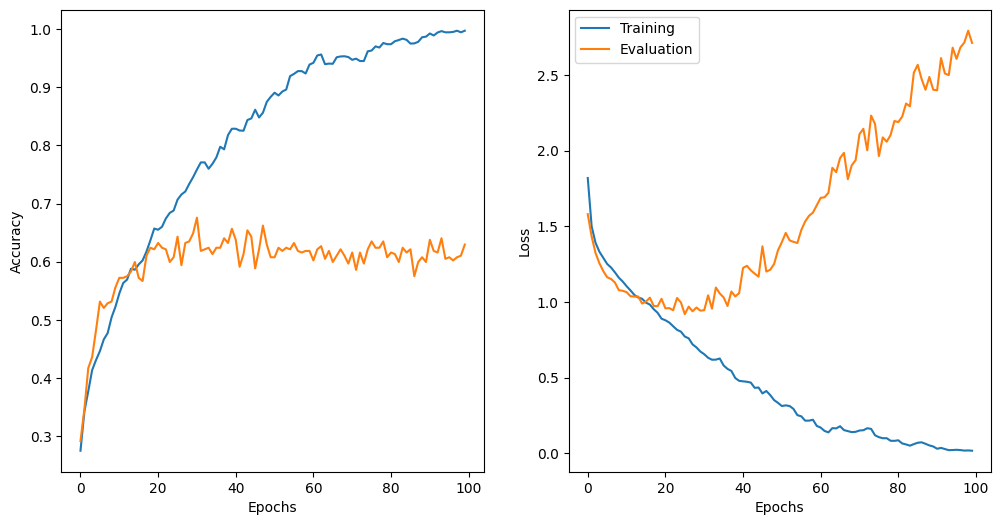

In [26]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [27]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_loader, device)
test_acc, test_loss

(0.6321525885558583, 2.7153289318084717)

#**Image Classification Vision Transformer Transfer Learning**

In [28]:
!pip install -q datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00


### **Modeling**

In [29]:
from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id,label in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### **Metric**

In [30]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

###**Trainer**

In [31]:
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [32]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
import torch

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

###**Training**

In [34]:
import wandb
wandb.init(mode='disabled')

In [35]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.929082,0.942779
2,No log,0.465102,0.961853
3,No log,0.298576,0.972752
4,No log,0.236216,0.970027
5,No log,0.211627,0.967302
6,No log,0.193294,0.970027
7,No log,0.185677,0.967302
8,No log,0.180292,0.961853
9,No log,0.177396,0.964578
10,No log,0.176434,0.964578


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=460, training_loss=0.325927502176036, metrics={'train_runtime': 746.942, 'train_samples_per_second': 39.307, 'train_steps_per_second': 0.616, 'total_flos': 2.2752259898322125e+18, 'train_loss': 0.325927502176036, 'epoch': 10.0})

In [36]:
outputs = trainer.predict(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
outputs.metrics

{'test_loss': 0.2967473864555359,
 'test_accuracy': 0.9782016348773842,
 'test_runtime': 3.8046,
 'test_samples_per_second': 96.462,
 'test_steps_per_second': 1.577}